data processing

In [1]:
import pandas as pd
import numpy as np
data_orders = pd.read_csv('/data/lab/STA326_Assignment2/datasets/data_orders.csv')
data_offers = pd.read_csv('/data/lab/STA326_Assignment2/datasets/data_offers.csv')

In [2]:
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [3]:
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [4]:
data_orders['order_datetime'] = pd.to_datetime(data_orders['order_datetime'])
#data_orders['m_order_eta'].fillna(0.0, inplace=True)
#data_orders['cancellations_time_in_seconds'].fillna(0.0, inplace=True)
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,2024-04-18 18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,2024-04-18 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,2024-04-18 12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,2024-04-18 13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,2024-04-18 21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [5]:
data_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


In [6]:
data_offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


q1

In [7]:
data_orders['is_driver_assigned_key'] = np.where(data_orders['is_driver_assigned_key']==1,'After Driver Assignment','Before Driver Assignment')
data_orders['order_status_key'] = np.where(data_orders['order_status_key']==4,'Client Cancelled','System Cancelled')
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,2024-04-18 18:08:07,-0.978916,51.456173,60.0,3000583041974,Client Cancelled,After Driver Assignment,198.0
1,2024-04-18 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client Cancelled,Before Driver Assignment,128.0
2,2024-04-18 12:07:50,-0.969520,51.455544,477.0,3000582891479,Client Cancelled,After Driver Assignment,46.0
3,2024-04-18 13:50:20,-1.054671,51.460544,658.0,3000582941169,Client Cancelled,After Driver Assignment,62.0
4,2024-04-18 21:24:45,-0.967605,51.458236,NaN,3000583140877,System Cancelled,Before Driver Assignment,NaN


In [8]:
cancellations = data_orders.groupby(['is_driver_assigned_key','order_status_key'])['order_gk'].count()
cancellations

is_driver_assigned_key    order_status_key
After Driver Assignment   Client Cancelled    2811
                          System Cancelled       3
Before Driver Assignment  Client Cancelled    4496
                          System Cancelled    3406
Name: order_gk, dtype: int64

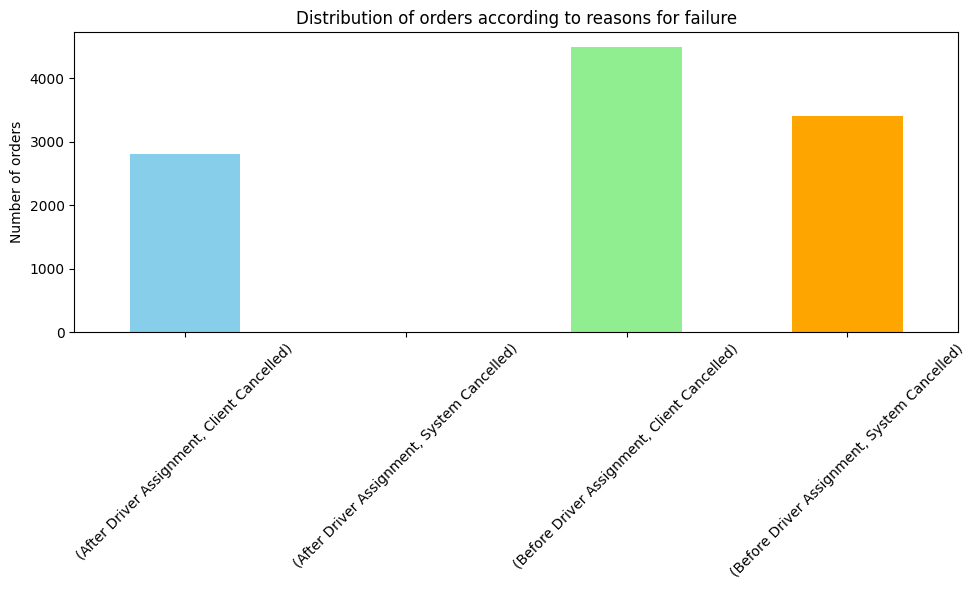

In [9]:
import matplotlib.pyplot as plt

# 假设你已经有了cancellations数据和它的对应的原因标签reasons

# 1. 选择明亮的颜色，并确保它们易于区分
colors = ['skyblue', 'salmon', 'lightgreen', 'orange']

# 2. 调整字体和标签，确保它们清晰可读
plt.figure(figsize=(10, 6))  # 调整图表大小
cancellations.plot(kind='bar', color=colors, legend=False, subplots=False, ylabel='Number of orders', title='Distribution of orders according to reasons for failure')
plt.xticks(rotation=45)  # 调整标签角度
plt.xlabel('')  # 移除底部标签
plt.tight_layout()  # 调整布局以防止标签重叠
plt.show()


Which category has the highest number of orders?

The category with the highest number of orders is when the driver is not assigned and the client cancelled the order, with a total of 4496 orders.

Analysis and Conclusion:

Cancellation Before Driver Assignment:

A significantly higher number of orders (4496) were cancelled by clients before a driver was assigned compared to those rejected by the system (3406). This suggests that a substantial portion of clients decided to cancel their orders due to extended waiting times for driver assignment.

Cancellation After Driver Assignment:

After a driver was assigned, the number of client cancellations decreased to 2811. This indicates that once a driver was assigned, there was a reduction in the number of cancellations by clients, possibly due to increased confidence in the likelihood of order completion.

System Rejections:

The number of orders rejected by the system after driver assignment is extremely low, suggesting that system rejections are less common compared to client cancellations. This could imply that the system rejection criteria are more stringent or less frequent compared to reasons leading to client cancellations.

Overall, the analysis suggests that optimizing the process of assigning drivers promptly after order placement could potentially reduce the number of cancellations by clients and improve overall order completion rates. Additionally, further investigation into the reasons for system rejections and potential improvements in the rejection criteria may also help minimize order rejections.

q2

In [10]:
data_orders['order_hour'] = data_orders.order_datetime.dt.hour
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,order_hour
0,2024-04-18 18:08:07,-0.978916,51.456173,60.0,3000583041974,Client Cancelled,After Driver Assignment,198.0,18
1,2024-04-18 20:57:32,-0.950385,51.456843,NaN,3000583116437,Client Cancelled,Before Driver Assignment,128.0,20
2,2024-04-18 12:07:50,-0.969520,51.455544,477.0,3000582891479,Client Cancelled,After Driver Assignment,46.0,12
3,2024-04-18 13:50:20,-1.054671,51.460544,658.0,3000582941169,Client Cancelled,After Driver Assignment,62.0,13
4,2024-04-18 21:24:45,-0.967605,51.458236,NaN,3000583140877,System Cancelled,Before Driver Assignment,NaN,21


In [11]:
details = data_orders.groupby(['order_hour','is_driver_assigned_key','order_status_key'])['order_gk'].count()
details

order_hour  is_driver_assigned_key    order_status_key
0           After Driver Assignment   Client Cancelled    120
                                      System Cancelled      2
            Before Driver Assignment  Client Cancelled    298
                                      System Cancelled    263
1           After Driver Assignment   Client Cancelled     88
                                                         ... 
22          Before Driver Assignment  Client Cancelled    326
                                      System Cancelled    241
23          After Driver Assignment   Client Cancelled    156
            Before Driver Assignment  Client Cancelled    378
                                      System Cancelled    302
Name: order_gk, Length: 74, dtype: int64

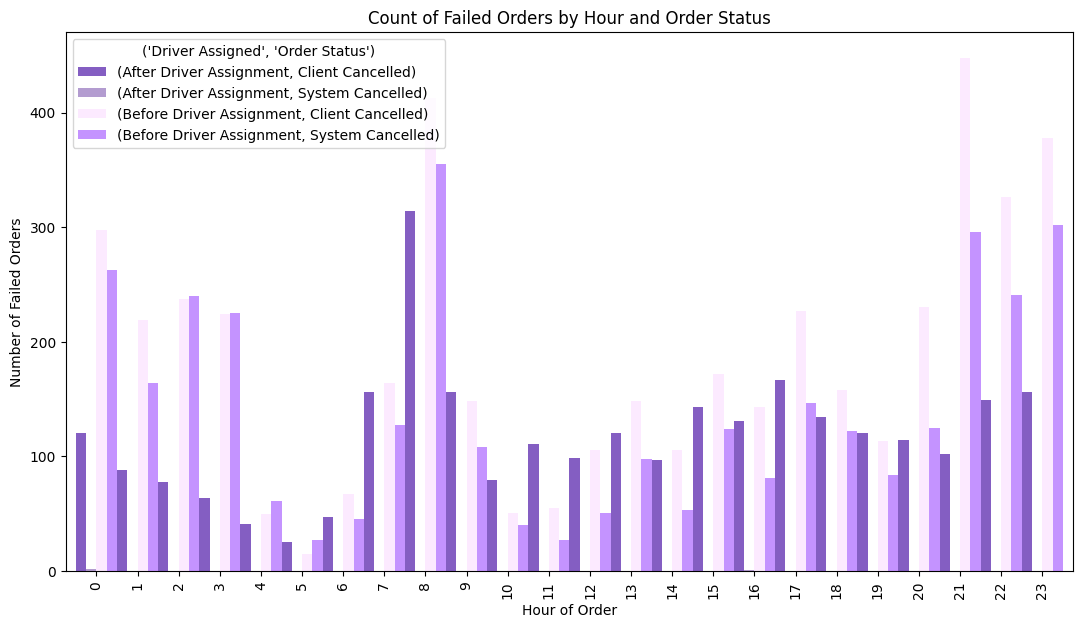

In [12]:
import matplotlib.pyplot as plt
details_reset = details.reset_index()

# Pivot the DataFrame to reshape it for plotting
pivot_data = details_reset.pivot(index='order_hour',
                            columns=['is_driver_assigned_key','order_status_key'],
                            values='order_gk')
colors = ['#845EC2', '#B39CD0', '#FCEAFF', '#C493FF']
# Plotting the bar chart
pivot_data.plot(kind='bar', xticks=range(0,24), figsize=(13,7), width=1, color= colors)

# Adding labels and title
plt.title('Count of Failed Orders by Hour and Order Status')
plt.xlabel('Hour of Order')
plt.ylabel('Number of Failed Orders')
plt.legend(title=('Driver Assigned', 'Order Status'))

# Displaying the plot
plt.show()

Is there a trend that certain hours have an abnormally high proportion of one category or another?

Upon examining the distribution of failed orders by hour, it's evident that the highest number of cancellations occurs at 21:00 When drivers are not assigned and cancellations are primarily due to client actions.

Additionally, the highest number of cancellations for all other categories peaked in the eighth hour.

The higher number of order cancellations at 21:00 may be possibly influenced by the following factors:

1. End of Specific Service Hours: Many restaurants and delivery services have designated closing times, often around 21:00, after which they stop accepting new orders. Customers may cancel existing orders if they realize they won't be able to receive them before the cutoff time.

2. Time Constraints: 21:00 is typically a time when people are winding down for the evening, and they may cancel orders if they feel they won't have enough time to enjoy their meal before bedtime.

3. Fatigue or Stress: Towards the end of the day, people may experience fatigue or stress, leading them to make impulsive decisions such as canceling orders they had previously placed.


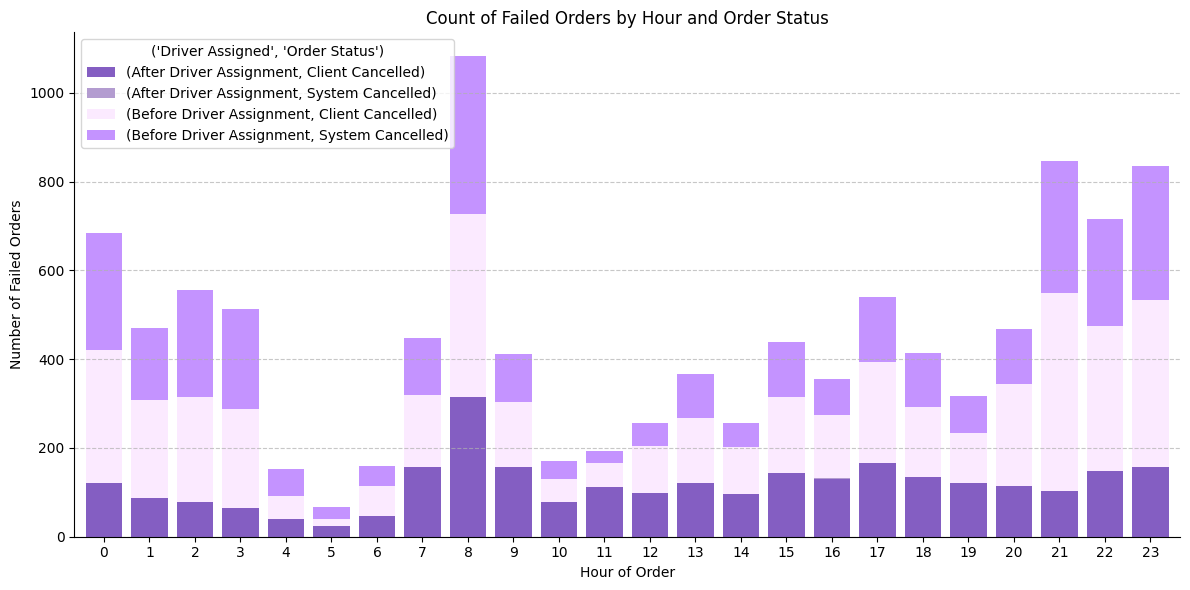

In [13]:
import matplotlib.pyplot as plt

# Reset index of details DataFrame
details_reset = details.reset_index()

# Pivot the DataFrame to reshape it for plotting
pivot_data = details_reset.pivot(index='order_hour',
                                 columns=['is_driver_assigned_key', 'order_status_key'],
                                 values='order_gk')

# Define colors
colors = ['#845EC2', '#B39CD0', '#FBEAFF', '#C493FF']

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
pivot_data.plot(kind='bar', stacked=True, ax=ax, width=0.8, color=colors)

# Adding labels and title
plt.title('Count of Failed Orders by Hour and Order Status')
plt.xlabel('Hour of Order')
plt.ylabel('Number of Failed Orders')
plt.xticks(rotation=0)
plt.legend(title=('Driver Assigned', 'Order Status'), loc='upper left')

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()


In this graph, we can clearly see both the total number of canceled orders for different hours and the distribution of various types of failed orders within the same hour. 

Particularly, we note the following 4 points:

1. Highest Total Failed Orders at the 8th Hour, followed by occurrences at 21:00 and 23:00.

Explanation:

At 8:00:

(1) Start of the Workday: Many people begin their workday or daily routines at 8:00. At this time, customers are keen on timely and accurate orders. If orders aren't fulfilled promptly, customers may cancel them and look for other options.

(2) Traffic Jams: 8:00 is usually the peak of rush hour, particularly in cities. Heavy traffic may delay drivers, causing customers to cancel orders due to expected delays.

For 21:00:

(1) Fatigue and Decreased Demand: Many people are winding down for the night, feeling tired and less inclined to keep previous plans, increasing the chance of cancellations.、

(2) Taxi Supply-Demand Gap: Demand for taxis surges in urban areas, but the number of available drivers may not meet the high demand, leading to cancellations.

(3) Technical Issues or System Failures: In the evening, when system load is high, there's a greater chance of technical problems. If the platform or app malfunctions, orders might not be processed promptly, leading to cancellations.

As for 23:00:

(1) Safety and Fatigue Concerns: Late-night hours may raise concerns about safety and personal tiredness. Customers may be more cautious about continuing their travel plans, increasing the likelihood of cancellations.

2. Lowest Total Failed Orders at the 5th Hour: The lower number of failed orders during the 5th hour could be attributed to factors such as potentially lower order volumes or more efficient order processing during this time period.

3. The majority of canceled orders occur before driver assignment at any given hour. This may be due to customers having limited patience for order processing, leading to cancellations when the system fails to promptly assign orders to drivers. 

4. While instances of system cancellation after driver assignment do occur, they are rare. This phenomenon might occur due to specific situations, such as delays in driver arrivals or temporary closures of restaurants. In such cases, the system automatically cancels orders to prevent unnecessary wait times or food wastage.

q3

We first removed the missing values from the dataset to facilitate subsequent data processing. This step ensures that we are not influenced by missing values when calculating the average cancellation time.

In [14]:
# Assuming q3 is your DataFrame
driver_data = data_orders.groupby(['order_hour', 'is_driver_assigned_key'])['cancellations_time_in_seconds'].apply(lambda x: [val for val in x if not pd.isna(val)]).reset_index()

# Show the resulting DataFrame
#print(driver_data)

Outliers identification: 

We use boxplots to visualize cancellation times with and without driver assignment for each hour of the day. Each subplot represents an hour, showing the distribution of cancellation times categorized by driver assignment. 

This visualization helps identify outliers and understand cancellation time variations throughout the day.

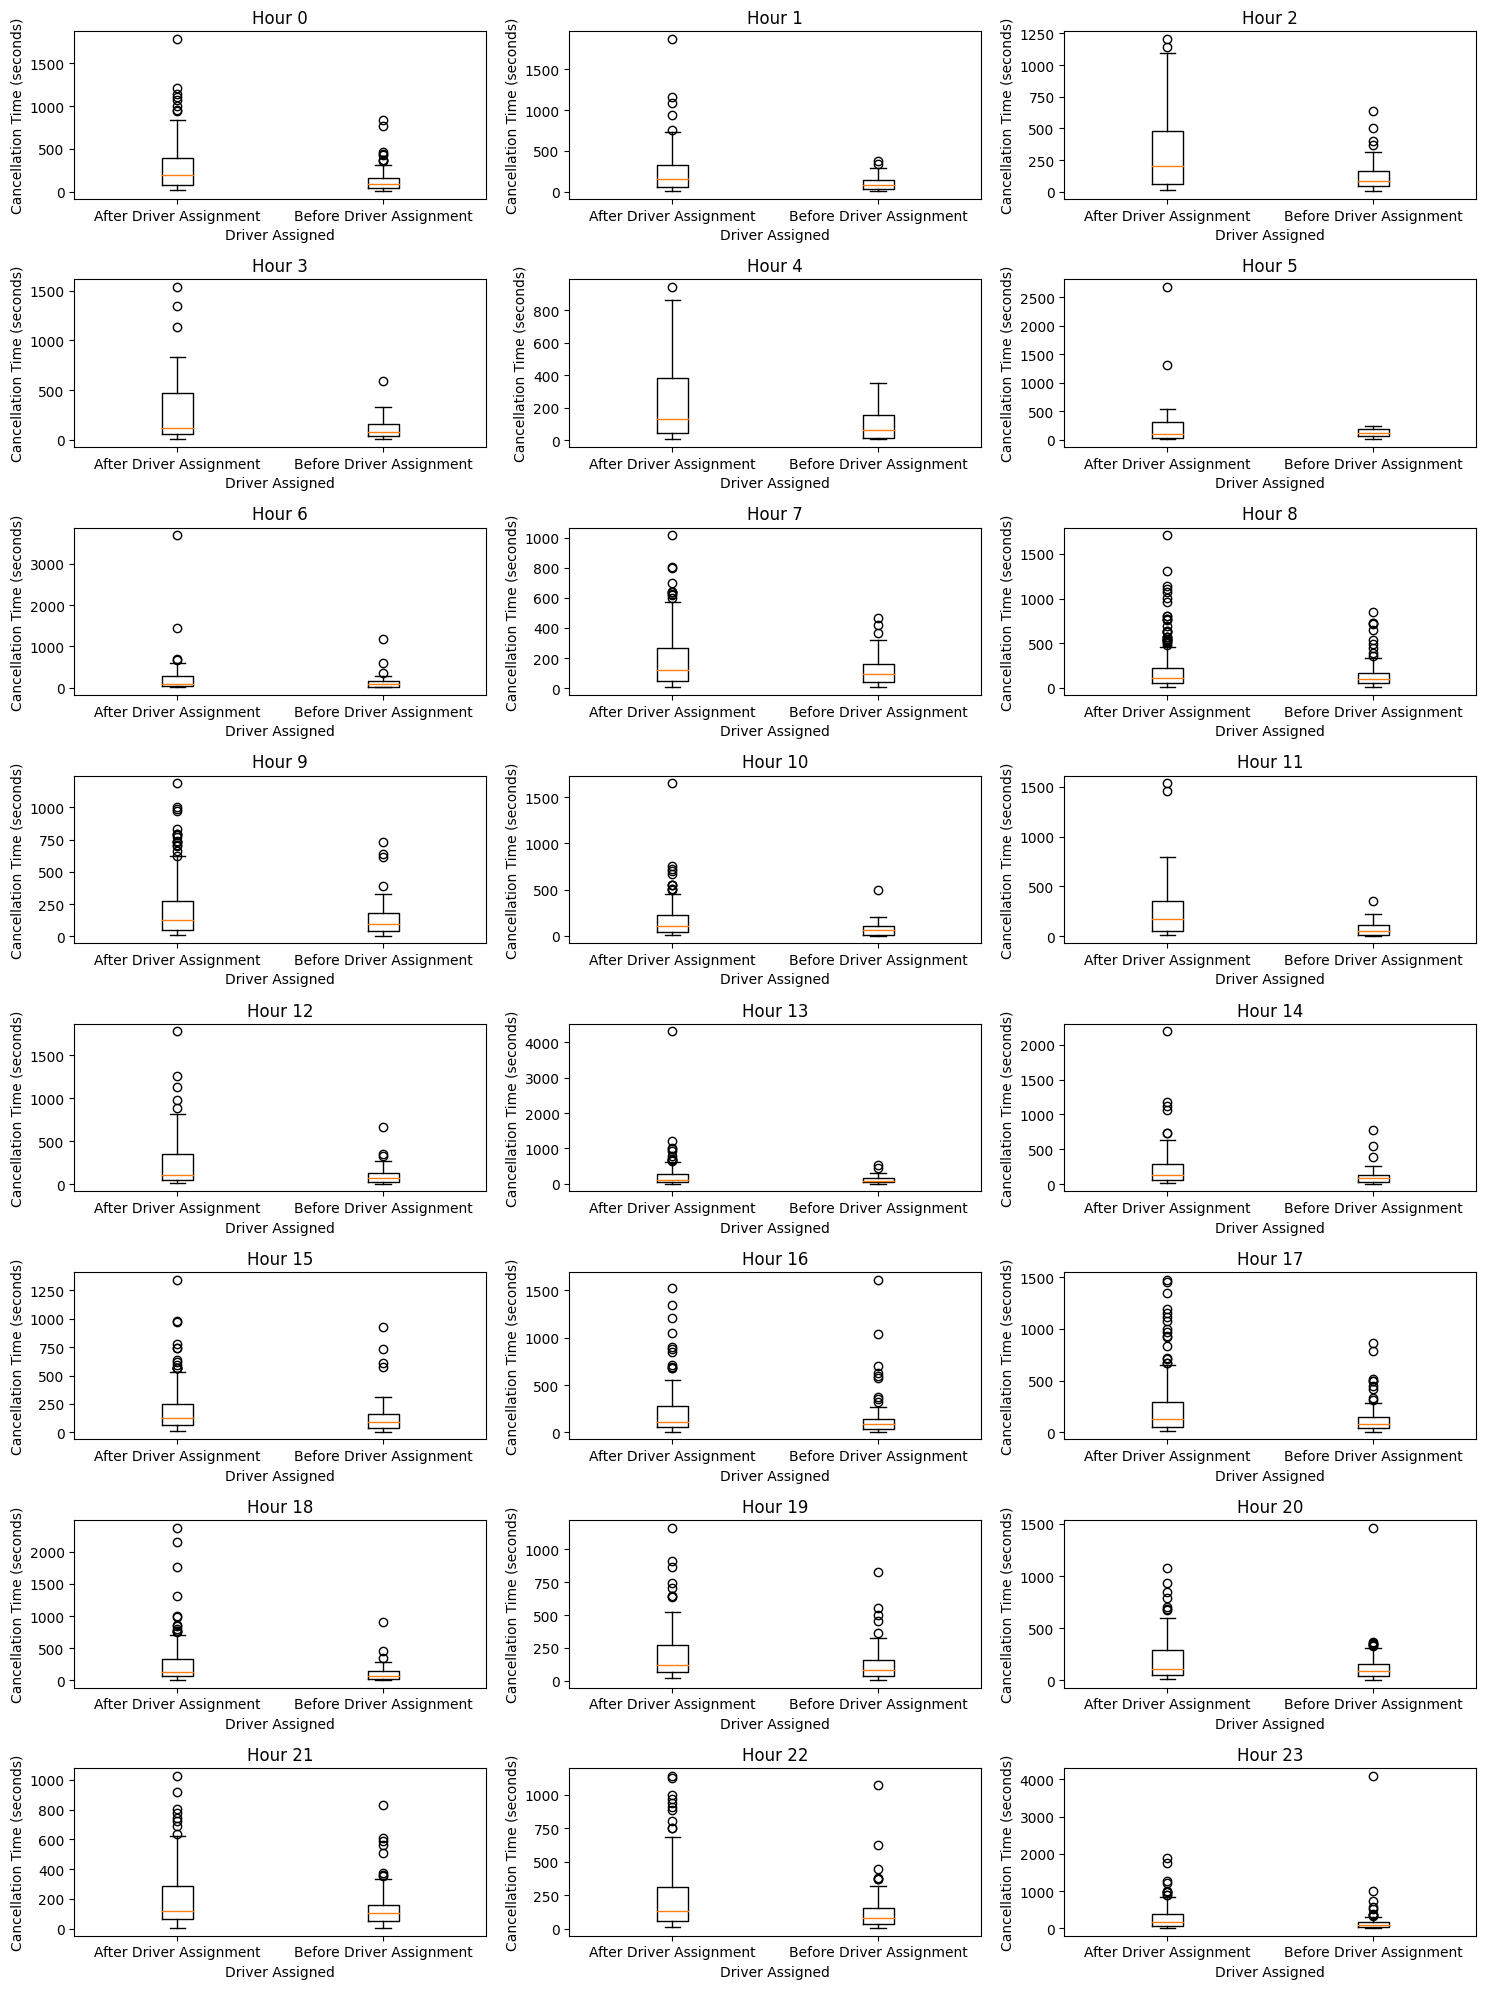

In [15]:
# Plot boxplot for each hour
plt.figure(figsize=(15, 20))
for i in range(24):
    plt.subplot(8, 3, i + 1)
    data_hour = driver_data[driver_data['order_hour'] == i]
    plt.boxplot(data_hour['cancellations_time_in_seconds'], labels=data_hour['is_driver_assigned_key'])
    plt.title(f'Hour {i}')
    plt.xlabel('Driver Assigned')
    plt.ylabel('Cancellation Time (seconds)')

plt.tight_layout()
plt.show()

Outlier processing:

Outliers were addressed by employing the interquartile range (IQR) method. 

This involved calculating the quartiles (Q1 and Q3) and the IQR for cancellation times in both categories: orders with a driver assigned after the order and those without a driver assigned before the order. 

Thresholds for outliers were then set at 1.5 times the IQR. Cancellation times falling outside these thresholds were considered outliers and subsequently filtered out. 

We also calculated the average cancellation time with and without driver for each hour for further conclusions.

Following the outlier removal process, we a lso plot the corresponding boxplots. A noticeable difference from the plots before outlier handling is observed.

Firstly, the interquartile ranges are tighter, indicating a more concentrated data distribution. 

Secondly, the lengths of the upper and lower whiskers are relatively shorter, indicating a more reasonable range of data distribution without outliers.  

Furthermore, by reducing the number of outliers, we've effectively mitigated the influence of extreme values on our analysis. This reduction not only enhances the visual clarity of the boxplots but also ensures that our statistical inferences are more robust and less susceptible to distortion from aberrant data points.

These enhancements enable us to analyze the hourly cancellation patterns more accurately, providing a more reliable basis for subsequent decision-making processes.

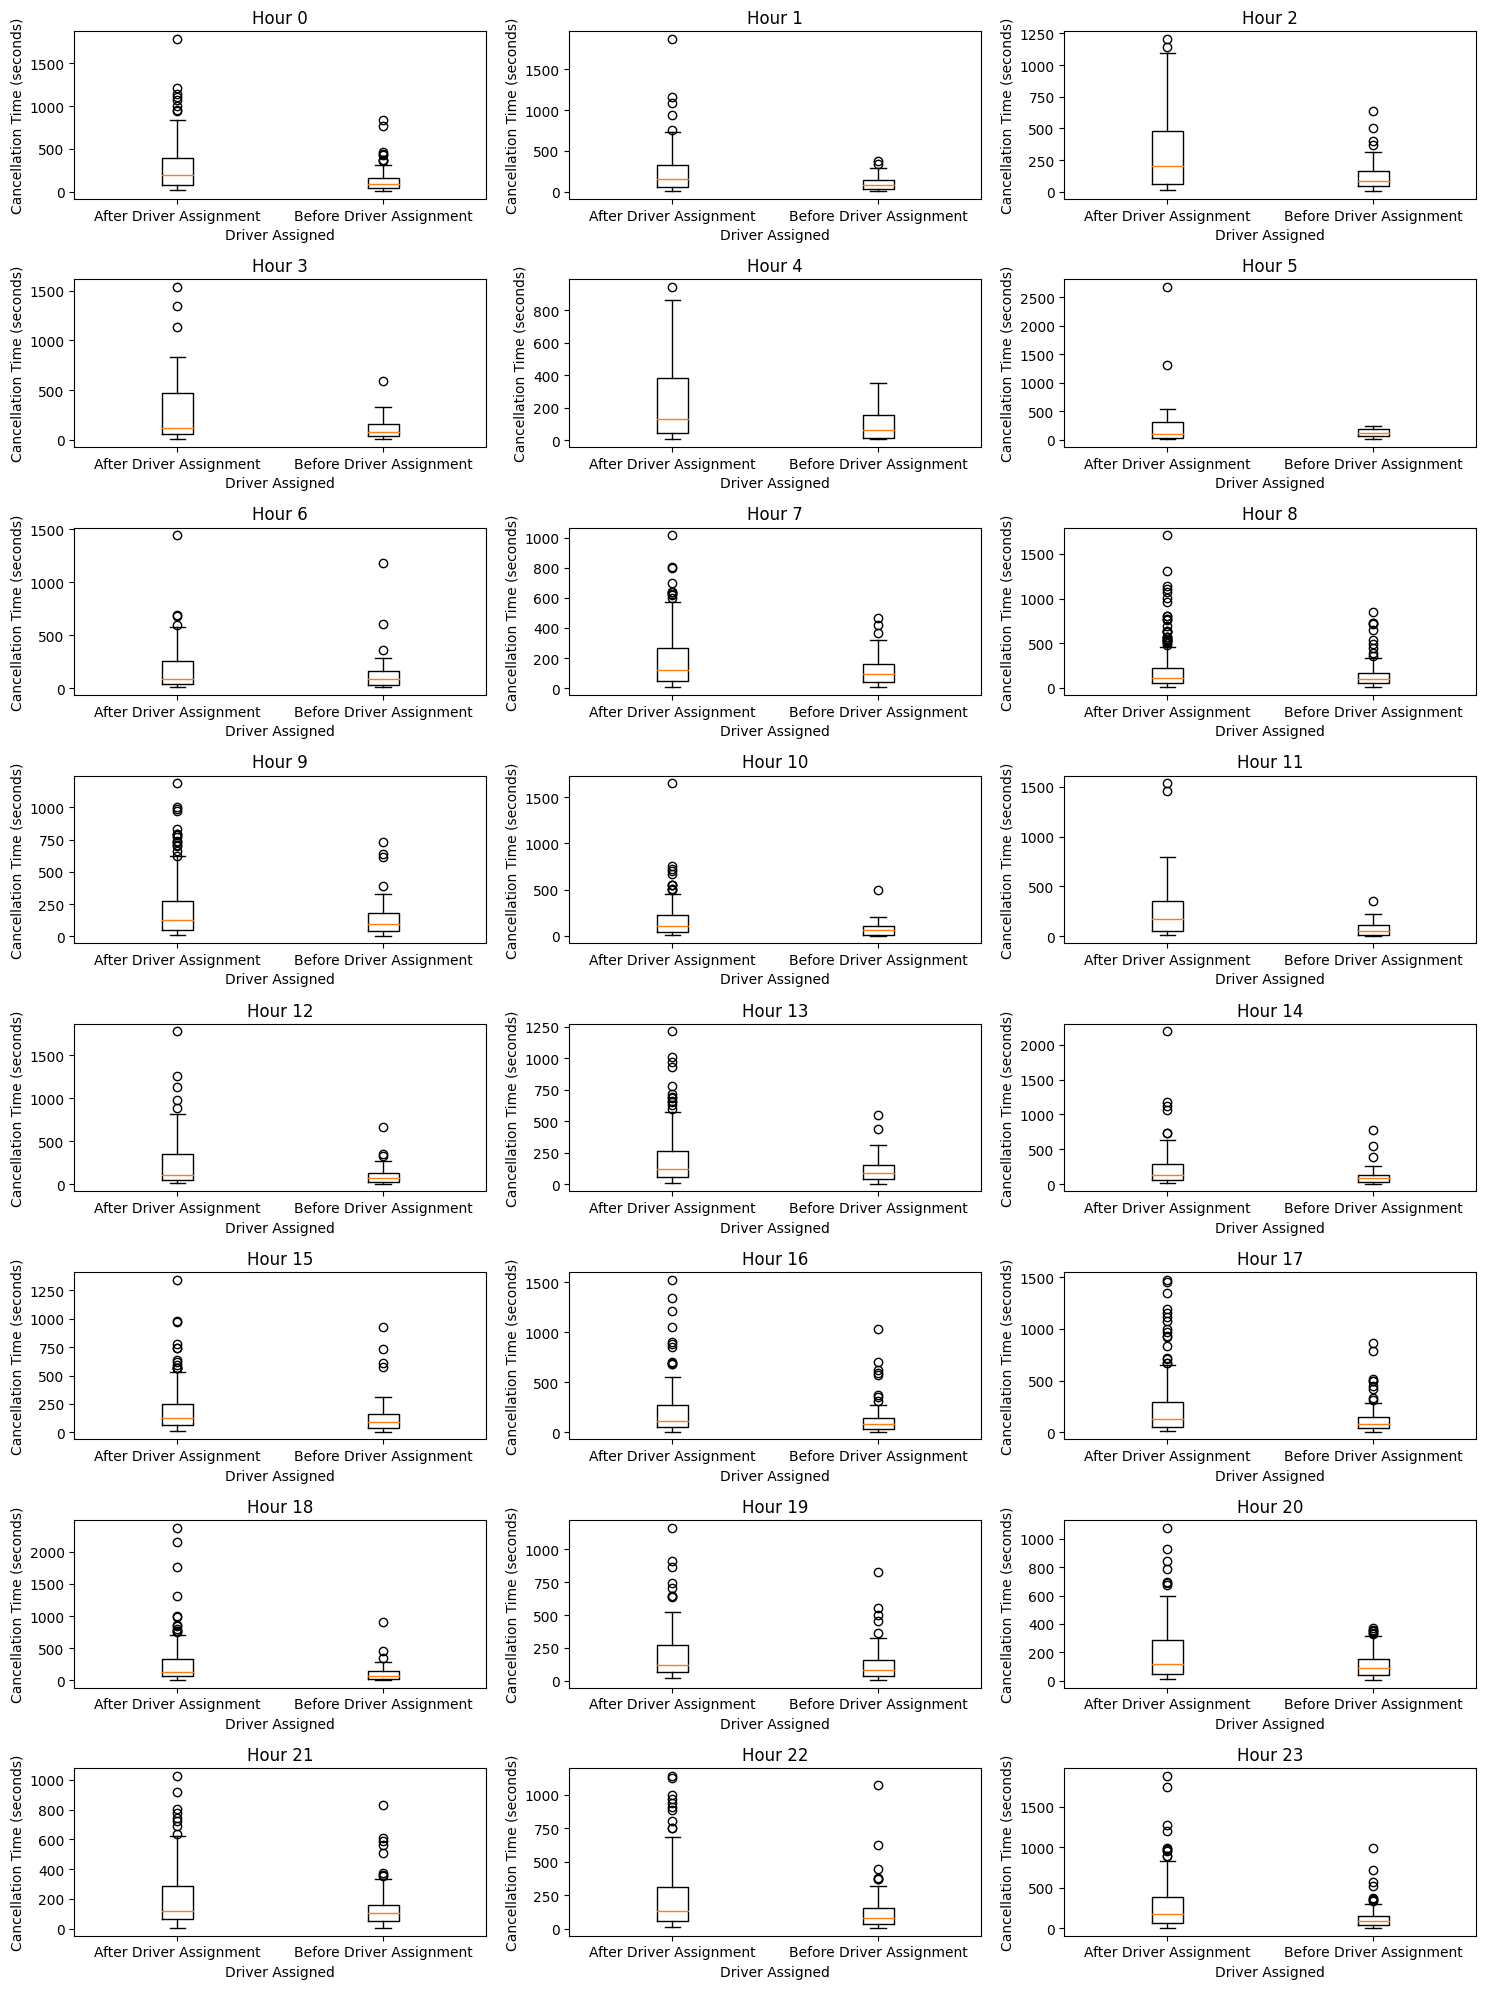

In [16]:
import numpy as np
plt.figure(figsize=(15, 20))
for i in range(24):
    plt.subplot(8, 3, i + 1)
    data_hour = driver_data[driver_data['order_hour'] == i]
    
    # Separate cancellation times for each driver assignment status
    cancellation_times_assigned = []
    cancellation_times_not_assigned = []
    for index, row in data_hour.iterrows():
        if row['is_driver_assigned_key'] == 'After Driver Assignment':
            cancellation_times_assigned.extend(row['cancellations_time_in_seconds'])
        else:
            cancellation_times_not_assigned.extend(row['cancellations_time_in_seconds'])

    # Calculate quartiles for both categories
    Q1_assigned = np.percentile(cancellation_times_assigned, 25)
    Q3_assigned = np.percentile(cancellation_times_assigned, 75)
    IQR_assigned = Q3_assigned - Q1_assigned
    
    Q1_not_assigned = np.percentile(cancellation_times_not_assigned, 25)
    Q3_not_assigned = np.percentile(cancellation_times_not_assigned, 75)
    IQR_not_assigned = Q3_not_assigned - Q1_not_assigned
    
    # Determine the threshold for outliers for both categories
    threshold_assigned = 10 * IQR_assigned
    threshold_not_assigned = 10 * IQR_not_assigned
    
    # Filter the cancellation times for both categories based on quartiles and threshold
    cancellation_times_filtered_assigned = [time for time in cancellation_times_assigned if time >= Q1_assigned - threshold_assigned and time <= Q3_assigned + threshold_assigned]
    cancellation_times_filtered_not_assigned = [time for time in cancellation_times_not_assigned if time >= Q1_not_assigned - threshold_not_assigned and time <= Q3_not_assigned + threshold_not_assigned]
    driver_data.loc[2*i, 'cancellations_time_in_seconds'] = sum(cancellation_times_filtered_assigned) / len(cancellation_times_filtered_assigned)
    driver_data.loc[2*i+1, 'cancellations_time_in_seconds'] = sum(cancellation_times_filtered_not_assigned) / len(cancellation_times_filtered_not_assigned)
    # Plot the boxplots with filtered cancellation times for both categories
    plt.boxplot([cancellation_times_filtered_assigned, cancellation_times_filtered_not_assigned], labels=['After Driver Assignment', 'Before Driver Assignment'])
    plt.title(f'Hour {i}')
    plt.xlabel('Driver Assigned')
    plt.ylabel('Cancellation Time (seconds)')

plt.tight_layout()
plt.show()


In [17]:
driver_data

,order_hour,is_driver_assigned_key,cancellations_time_in_seconds
0,0,After Driver Assignment,293.616667
1,0,Before Driver Assignment,111.557047
2,1,After Driver Assignment,247.715909
3,1,Before Driver Assignment,98.13242
4,2,After Driver Assignment,303.307692
5,2,Before Driver Assignment,106.438819
6,3,After Driver Assignment,292.640625
7,3,Before Driver Assignment,104.361607
8,4,After Driver Assignment,243.219512
9,4,Before Driver Assignment,90.0


<Figure size 1000x600 with 0 Axes>

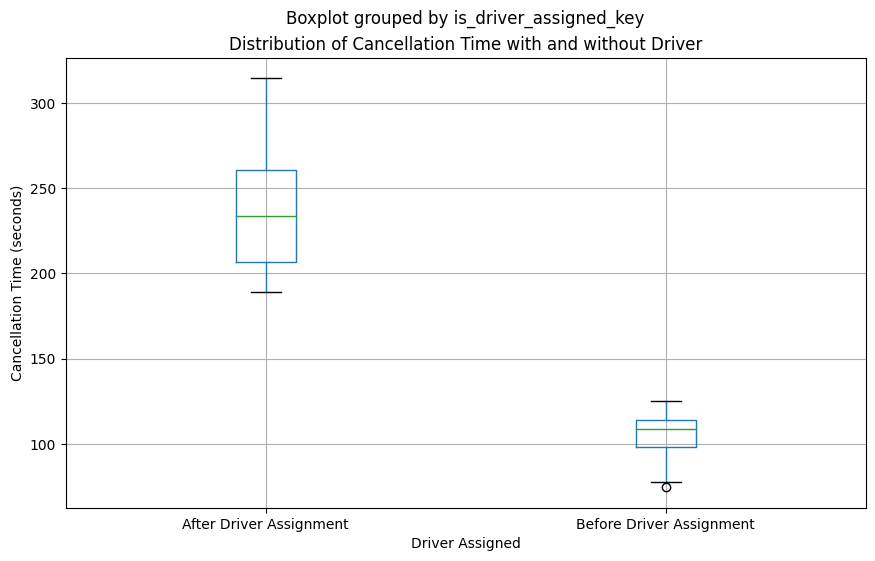

In [18]:
import matplotlib.pyplot as plt

# Reset index of driver DataFrame
driver_reset = driver_data.reset_index()

# Create a boxplot
plt.figure(figsize=(10, 6))
boxplot = driver_reset.boxplot(column='cancellations_time_in_seconds', by='is_driver_assigned_key', figsize=(10, 6))

# Set labels and title
plt.title('Distribution of Cancellation Time with and without Driver')
plt.xlabel('Driver Assigned')
plt.ylabel('Cancellation Time (seconds)')

# Show plot
plt.show()


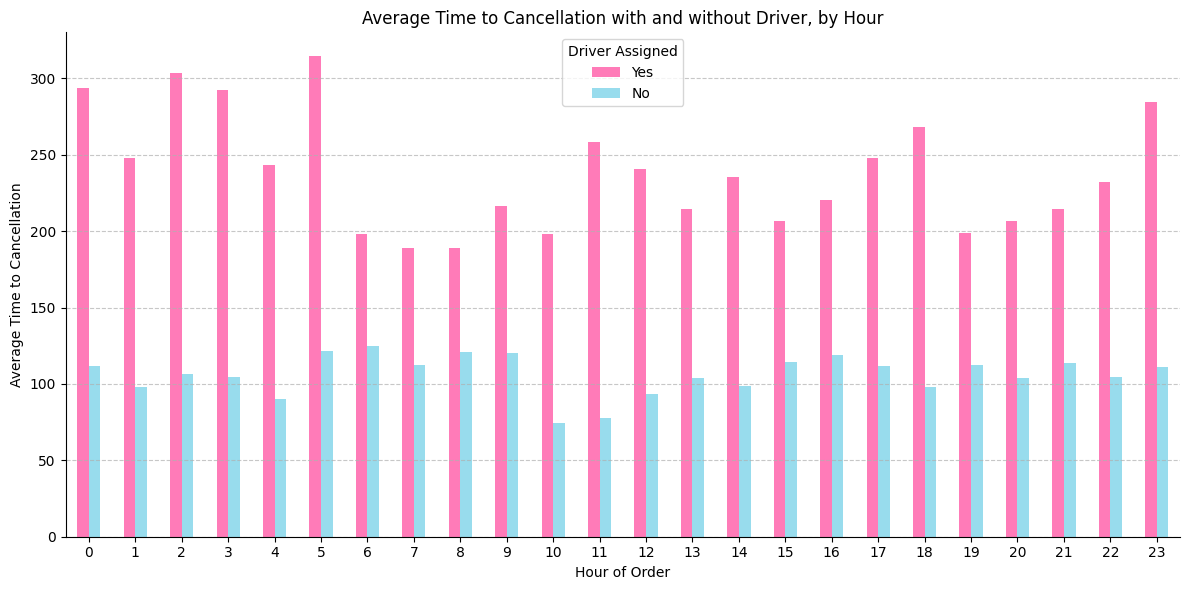

In [19]:
import matplotlib.pyplot as plt

# Reset index of the driver DataFrame
driver_reset = driver_data.reset_index()

# Pivot the DataFrame to reshape it for plotting
pivot_data = driver_reset.pivot(index='order_hour',
                                 columns='is_driver_assigned_key',
                                 values='cancellations_time_in_seconds')

# Define colors
colors = ['#FF7BB8', '#98DCED']

# Plotting the bar chart
fig, ax = plt.subplots(figsize=(12, 6))
pivot_data.plot(kind='bar', ax=ax, color=colors)

# Adding labels and title
plt.title('Average Time to Cancellation with and without Driver, by Hour')
plt.xlabel('Hour of Order')
plt.ylabel('Average Time to Cancellation')
plt.xticks(rotation=0)
plt.legend(title='Driver Assigned', labels=['Yes','No'])

# Adding grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Show plot
plt.tight_layout()
plt.show()


Conclusions:
    The average time to cancellation is consistently higher when a driver is assigned compared to when no driver is assigned. This may be attributed to several factors:

1. Communication Issues: There could be communication challenges between the platform, the driver, and the customer, leading to delays in cancellation confirmation.
    
2. Service Levels: Customers might have higher expectations or patience levels when a driver is assigned, potentially waiting longer before cancelling compared to when no driver is assigned.



The highest average cancellation time is observed at Hour 5, followed by a peak at Hour 2. This could be attributed to several factors:

1. Low Order Volume: Through q2, it can be found that the number of cancellations at Hour 5 is particularly small. Therefore, any delays or disruptions in service, such as traffic congestion, adverse weather conditions, or technical glitches with the platform, can have a more pronounced impact on the average cancellation time due to the smaller sample size.

2. Difficulty in Finding Rides: During off-peak hours like Hour 5, customers may encounter challenges in finding available taxis due to lower driver availability or increased demand. Consequently, customers may be willing to wait longer before cancelling their orders, leading to a higher average cancellation time.

q4

In [20]:
q4 =  data_orders.dropna(subset=['m_order_eta'])

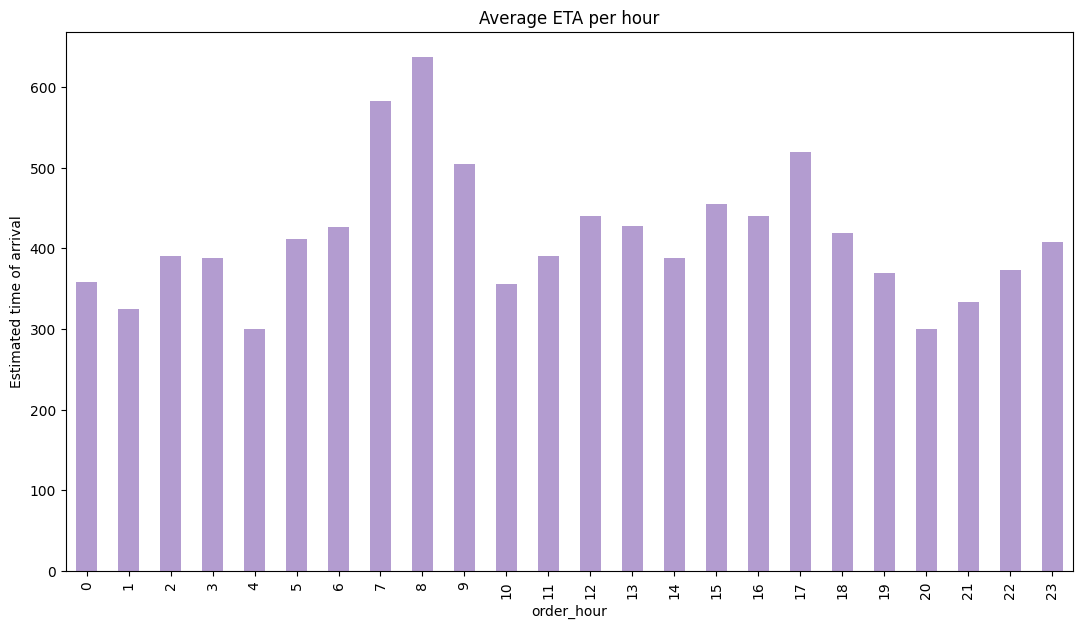

In [21]:
_ = q4.groupby('order_hour')['m_order_eta'].mean().plot(kind='bar',figsize=(13,7),ylabel='Estimated time of arrival',
                     title="Average ETA per hour", color = '#B39CD0')

The longest waiting time occurs at 8 a.m., followed by 7 a.m., and closely followed by 5 p.m. The  phenomenon could be attributed to several reasons:

Peak Hours: These times typically represent peak hours during the day when there is a surge in orders being placed. If the order volume exceeds the system's processing capacity, it leads to increased waiting times.

High Foot Traffic: These periods witness higher foot traffic, such as people commuting to work or school in the morning and returning home after work in the evening. This increased foot traffic can make stores or restaurants busier, resulting in longer order processing times.

System or Equipment Failures: During peak hours, the system load may be high, causing slower response times or system failures. Additionally, equipment failures can also slow down order processing and increase waiting times.

What's more, the bar chart closely correlates with the count of failed orders per hour, suggesting that as the average waiting time for customers increases, there is a corresponding increase in the frequency of order cancellations.

Addressing these issues may involve measures such as forecasting peak-hour order volumes, optimizing staffing levels, improving traffic routes, and ensuring the stability and reliability of systems and equipment. Implementing these measures can help reduce waiting times, enhance customer satisfaction, and decrease order cancellation rates.

q5

In [22]:
import h3
import folium
data_orders["hex_id"] = data_orders.apply(
    func=lambda row: h3.geo_to_h3(lat=row["origin_latitude"], lng=row["origin_longitude"],\
                                  resolution=8), axis=1)
grouped = data_orders.groupby(by='hex_id')["order_gk"].count()
grouped.shape

(144,)

In [23]:
grouped = grouped.reset_index()
grouped.head()

,hex_id,order_gk
0,88195d2801fffff,26
1,88195d2803fffff,11
2,88195d2805fffff,8
3,88195d2807fffff,1
4,88195d2809fffff,16


In [24]:
grouped = grouped.sort_values(by="order_gk",ascending=False) # 1
total_orders = grouped["order_gk"].sum() # 2
grouped["cum_sum"] = grouped["order_gk"].cumsum() # 3
grouped["cum_perc"] = 100 * grouped["cum_sum"] / total_orders # 4
grouped[grouped["cum_perc"] <= 81] # 5

,hex_id,order_gk,cum_sum,cum_perc
97,88195d2b1dfffff,1497,1497,13.969765
96,88195d2b1bfffff,870,2367,22.088466
93,88195d2b15fffff,774,3141,29.311310
91,88195d2b11fffff,707,3848,35.908921
95,88195d2b19fffff,667,4515,42.133259
20,88195d284dfffff,653,5168,48.226950
63,88195d2a27fffff,414,5582,52.090332
89,88195d2b0bfffff,372,5954,55.561777
62,88195d2a25fffff,362,6316,58.939903
92,88195d2b13fffff,346,6662,62.168720


In [25]:
grouped = grouped[grouped["cum_perc"] <= 81]

In [26]:
grouped[grouped["cum_perc"] <= 81].count()

hex_id      24
order_gk    24
cum_sum     24
cum_perc    24
dtype: int64

It indicates that approximately 80% of the data is encompassed within these 24 hexagons, with a total of 144 rows in the final output.

In [27]:
map = folium.Map(location=[data_orders["origin_latitude"].mean(), data_orders["origin_longitude"].mean()],
 zoom_start=8.5, # after a bit of experimentation, I thought this presents the map best
 tiles="OpenStreetMap"
 )
import json
import geojson
def to_geojson(row):    
    """
    Transform hex_id into a geojson object.
    """
    geometry = {
    "type": "Polygon",
    "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"], geo_json=True)]
                }
    result = geojson.Feature(id=row["hex_id"], geometry=geometry, properties={"order_gk":row['order_gk']})
    return result
                                                                                                                                                
geojsons = grouped.apply(func=to_geojson, axis=1).values.tolist()
geojson_str: str = json.dumps(geojson.FeatureCollection(geojsons))
                                                                              
import matplotlib
# instantiate a colormap object for better visualisation
colormap = matplotlib.cm.get_cmap(name="coolwarm")
max_order_gk = grouped["order_gk"].max()
min_order_gk = grouped["order_gk"].min()

/tmp/ipykernel_13525/3287735885.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap(name="coolwarm")


In [28]:
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
 "fillColor": matplotlib.colors.to_hex(
 colormap((f["properties"]["order_gk"]-min_order_gk)/(max_order_gk - min_order_gk))),
 "color": "black",
 "weight": 1,
 "fillOpacity": 0.7
}).add_to(map)
map